In [2]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        
    def forward(self, x):
        fx = self.conv1(x)
        fx = self.relu(fx)
        fx = self.conv2(fx)
        out = x + fx
        out = self.relu(out)
        
        return out



class EVSRNet(nn.Module):
    def __init__(self, scale_factor=4, input_shape=(3, None, None)):
        super(EVSRNet, self).__init__()
        self.scale_factor = scale_factor
        self.input_shape = input_shape
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, padding=1)
        self.res1 = ResidualBlock()
        self.res2 = ResidualBlock()
        self.res3 = ResidualBlock()
        self.res4 = ResidualBlock()
        self.res5 = ResidualBlock()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=input_shape[0] * (scale_factor ** 2), kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.depth_to_space = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.conv2(x)
        x = self.relu(x)
        out = self.depth_to_space(x)
        
        return out

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import torch
import cv2

model = EVSRNet()
#model.load_state_dict(torch.load('C:/Users/MOBED/230306_5pm_loss0037.pth'))
model.eval()

EVSRNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res2): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res3): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res4): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res5): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r

In [5]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import numpy as np

T2T = ToTensor() # numpy or PIL_Image to Tensor
T2P = ToPILImage() # Tensor to PIL_Image


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
## 백업용 train code
### 실제 실행 시켜야하는건 아래 수정한 train code
import os
from tqdm import tqdm

def train(model, model_name, scale, data_path, num_epochs=2, batch_size=4):
    os.makedirs("./Checkpoints/", exist_ok=True)
    before_loss = 100
    
    train_set = SRDataset(lr_root=data_path + "X{}/".format(scale), hr_root=data_path + "X1/")
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ",device)
    model.to(device)
    
    for epoch in range(num_epochs):
        train_loss = 0
        model.train()        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            # print('data shape : ',data.shape) # (N x C X H X W)
            # print('data : ',data)
            # print('target shape : ',target.shape) # (N x C X H X W)
            # print('target : ',target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss/len(train_loader)))
        if ((train_loss/len(train_loader)) <= before_loss):
            before_loss = train_loss/len(train_loader)
            torch.save(model.state_dict(), "./Checkpoints/{}.pth".format(model_name))

In [8]:
import os
from tqdm import tqdm

os.makedirs("./Checkpoints/", exist_ok=True)


def train(model, model_name, scale, data_path, num_epochs=2, batch_size=1):
    
    test_hr = cv2.imread(data_path)
    test_hr = cv2.cvtColor(test_hr,cv2.COLOR_BGR2RGB)
    test_hr = cv2.resize(test_hr,(480*4,270*4),interpolation=cv2.INTER_CUBIC)
    test_hr = test_hr.astype(np.float32)
    test_hr = test_hr / 255.
    test_lr = cv2.resize(test_hr,(480,270),interpolation=cv2.INTER_CUBIC)
    test_lr = torch.from_numpy(np.transpose(test_lr,(2,0,1))).float()
    test_hr = torch.from_numpy(np.transpose(test_hr,(2,0,1))).float()
    test_lr = torch.unsqueeze(test_lr,0)
    test_hr = torch.unsqueeze(test_hr,0)
    
    before_loss = 100
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ",device)
    model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        model.train()    
            
        test_lr, test_hr = test_lr.to(device), test_hr.to(device) # data = test_lr, target = test_hr
        # print('data shape : ',data.shape) # (N x C X H X W)
        # print('data : ',data)
        # print('target shape : ',target.shape) # (N x C X H X W)
        # print('target : ',target)
        optimizer.zero_grad()
        output = model(test_lr)
        loss = criterion(output, test_hr) # criterion(data, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    print('Training Loss: {:.8f}'.format(train_loss/num_epochs))
    if ((train_loss/num_epochs) <= before_loss):
        before_loss = train_loss/num_epochs
        torch.save(model.state_dict(), "./Checkpoints/{}.pth".format(model_name))
        
    # output = torch.squeeze(output,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # output = T2P(output)
    # test_hr = torch.squeeze(test_hr,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # test_hr = T2P(test_hr)
    # plt.imshow(output)
    # plt.show()
    # plt.imshow(test_hr)
    # plt.show()

In [295]:
train(model, "evsrnet_t_x4", scale=4, data_path='C:/Users/MOBED/Pictures/Screenshots/test_frame1.png', num_epochs=10000, batch_size=1)

device :  cuda


100%|██████████| 10000/10000 [02:57<00:00, 56.44it/s]

Training Loss: 0.00000048


In [351]:
train(model, "evsrnet_t_x4", scale=4, data_path='C:/Users/MOBED/Omni_Ingest/Sample_data/lol_sample1.png', num_epochs=5000, batch_size=1)

device :  cuda


100%|██████████| 5000/5000 [04:00<00:00, 20.80it/s]

Training Loss: 0.00000013


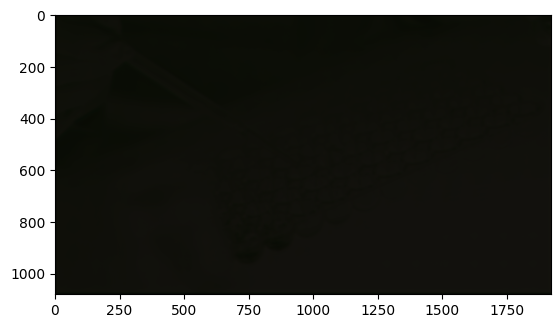

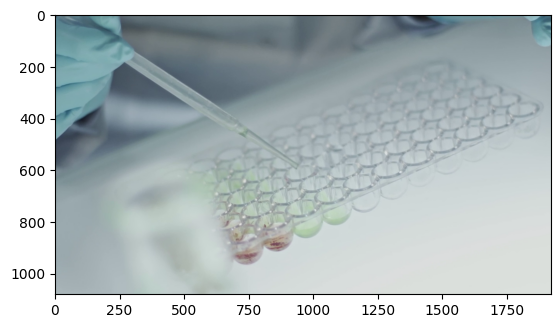

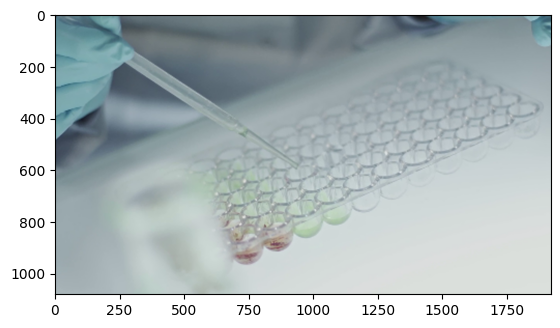

In [10]:
import cv2

# SR test function
lr_img = cv2.imread('C:/Users/MOBED/Omni_Ingest/Sample_data/output_sample.png')
lr_img = cv2.cvtColor(lr_img,cv2.COLOR_BGR2RGB)
test  = cv2.resize(lr_img,(480*4,270*4),interpolation=cv2.INTER_CUBIC) # dsize(width, height)

lr_img = cv2.resize(lr_img,(480,270),interpolation=cv2.INTER_CUBIC) # dsize(width, height)
bi_img  = cv2.resize(lr_img,(480*4,270*4),interpolation=cv2.INTER_CUBIC) # dsize(width, height)

lr_img = lr_img.astype(np.float32)
lr_img = lr_img / 255.
lr_img = torch.from_numpy(np.transpose(lr_img,(2,0,1))).float()
lr_img = torch.unsqueeze(lr_img,0) # numpy(C x H x W) -> tensor(N x C x H x W)
lr_img = lr_img.to(device)

model.eval()
model.to(device)
sr_img = model(lr_img)

sr_img = torch.squeeze(sr_img,0) # tensor(N x C x H x W) -> numpy(C x H x W)
sr_img = T2P(sr_img)

plt.imshow(sr_img)
plt.show()

plt.imshow(test)
plt.show()

plt.imshow(bi_img)
plt.show()

In [12]:
def train_w_img(model, model_name, scale, data, num_epochs=2, batch_size=1):
    
    test_hr = data
    test_hr = cv2.cvtColor(test_hr,cv2.COLOR_BGR2RGB)
    test_hr = cv2.resize(test_hr,(480*4,270*4),interpolation=cv2.INTER_CUBIC)
    test_hr = test_hr.astype(np.float32)
    test_hr = test_hr / 255.
    test_lr = cv2.resize(test_hr,(480,270),interpolation=cv2.INTER_CUBIC)
    test_lr = torch.from_numpy(np.transpose(test_lr,(2,0,1))).float()
    test_hr = torch.from_numpy(np.transpose(test_hr,(2,0,1))).float()
    test_lr = torch.unsqueeze(test_lr,0)
    test_hr = torch.unsqueeze(test_hr,0)
    
    before_loss = 100
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ",device)
    model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        model.train()    
            
        test_lr, test_hr = test_lr.to(device), test_hr.to(device) # data = test_lr, target = test_hr
        # print('data shape : ',data.shape) # (N x C X H X W)
        # print('data : ',data)
        # print('target shape : ',target.shape) # (N x C X H X W)
        # print('target : ',target)
        optimizer.zero_grad()
        output = model(test_lr)
        loss = criterion(output, test_hr) # criterion(data, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    if ((train_loss/num_epochs) <= before_loss):
        print('Training Loss: {:.8f}'.format(train_loss/num_epochs))
        before_loss = train_loss/num_epochs
        torch.save(model.state_dict(), "./Checkpoints/{}.pth".format(model_name))
        
    # output = torch.squeeze(output,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # output = T2P(output)
    # test_hr = torch.squeeze(test_hr,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # test_hr = T2P(test_hr)
    # plt.imshow(output)
    # plt.show()
    # plt.imshow(test_hr)
    # plt.show()

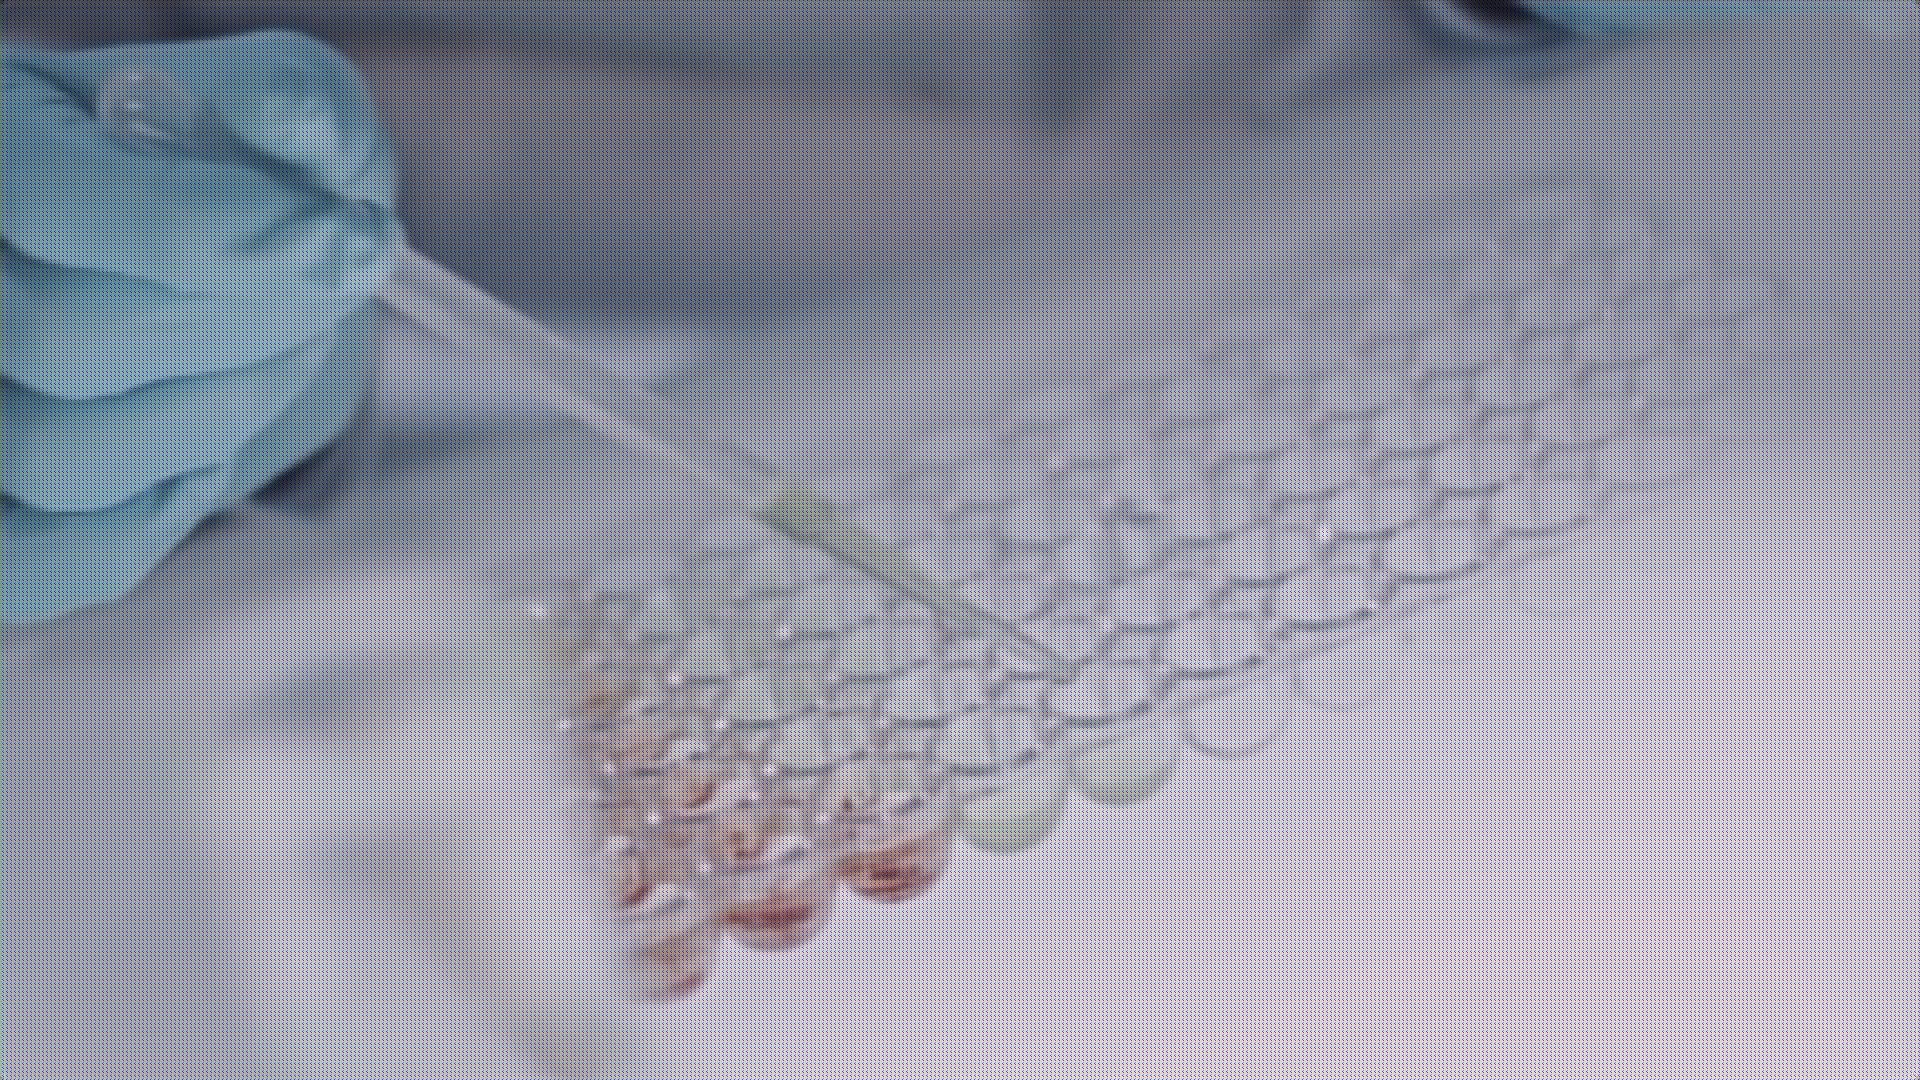

device :  cuda


 36%|███▌      | 18/50 [00:00<00:00, 48.56it/s]


KeyboardInterrupt: 

In [17]:
import cv2
from IPython.display import clear_output, display
from PIL import Image
import ipywidgets as widgets
import time

url = 'rtmp://165.132.105.190:1935/Arbba/firststream1'

# Open the video stream
cap = cv2.VideoCapture(url)

while True:
    # Read a frame from the video stream
    ret, frame = cap.read()

    if not ret:
        # Exit the loop if there is no frame
        break
    
    # Convert the frame from BGR to RGB format
    
    train_w_img(model, "evsrnet_t_x4", scale=4, data=frame, num_epochs=50, batch_size=1)
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB,)
    
    lr_frame = cv2.resize(frame,dsize=(480,270),interpolation=cv2.INTER_CUBIC)
    lr_frame = lr_frame.astype(np.float32)
    lr_frame = lr_frame / 255.
    lr_frame = torch.from_numpy(np.transpose(lr_frame,(2,0,1))).float()
    lr_frame = torch.unsqueeze(lr_frame,0) # numpy(C x H x W) -> tensor(N x C x H x W)
    lr_frame = lr_frame.to(device)

    model.eval()
    model.to(device)
    sr_frame = model(lr_frame)

    sr_frame = torch.squeeze(sr_frame,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    sr_frame = T2P(sr_frame)
    
    # Display the frame
    clear_output(wait=True)
    # display(Image.fromarray(frame))
    display(sr_frame)
    # Wait for 0.5 seconds
    time.sleep(0.1)
    
# Release the video stream
cap.release() 

In [380]:
# -*- coding: utf-8 -*-
import numpy as np
import math

# 무작위 입력값과 결과값 생겅하기
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# 가중치 무작위로 초기화하기
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # 순전파 : 예측된 y 계산하기
    # y = a + b x + x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3
    # 손실 계산하고 추력하기
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)
        
    # 손실에 대한 a, b, c, d의 변화도를 계산하기 위한 역전파
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()
    
    # 가중치 갱신하기
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d
    
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

99 652.122443960476
199 463.24560850928225
299 329.86324757477905
399 235.65492500847893
499 169.1072069369077
599 122.09325139445177
699 88.87574409869634
799 65.40369591085589
899 48.8163884852961
999 37.093377390995926
1099 28.8075017593909
1199 22.950554403538586
1299 18.810216667244575
1399 15.883169305136281
1499 13.813736254613376
1599 12.350552412118908
1699 11.315956777297092
1799 10.584371320541575
1899 10.067025783283803
1999 9.701164705977218
Result: y = -0.031351605055279334 + 0.8592575390473948 x + 0.005408673564995653 x^2 + -0.09368836712726356 x^3


In [ ]:
import cv2

cam = cv2.VideoCapture(0)

while True:
    ret, frame = cam.read()
    if not ret:
        break
    cv2.imshow('camera', frame)
    if cv2.waitKey(q) != -1:
        break
    
cam.release()
cv2.destroyAllWindows()